# Trainable GFRFT: Filtering

In [1]:
from pathlib import Path
from typing import Iterable, List

import torch as th
import torch.nn as nn
from filtering import GFRFTFilterLayer, Real
from torch_gfrft import EigvalSortStrategy
from torch_gfrft.gfrft import GFRFT
from torch_gfrft.gft import GFT
from utils import (
    add_gaussian_noise,
    init_knn_from_mat,
    mse_loss,
    rmse_loss,
    seed_everything,
)

In [2]:
SEED = 0
NODE_DIM = 0
NUM_NODES = 100
TIME_LENGTH = 200
ORIGINAL_ORDER = 0.35
LEARNING_RATE = 5e-4
EPOCHS = 2000
EIGVAL_SORT_STRATEGY = EigvalSortStrategy.TOTAL_VARIATION
SYMMETRIC = False
SELF_LOOPS = False
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

KNN_COUNT = 10
KNN_SIGMA = None
MAX_NODE_COUNT = 100
MAX_TIME_LENGTH = 120
GRAPH_VERBOSE = True

## Import Real-World Data and Generate Graph with Joint Time-Vertex Signal

Dataset Info:
	name: sea-surface-temperature
	node count: 100
	time length: 120


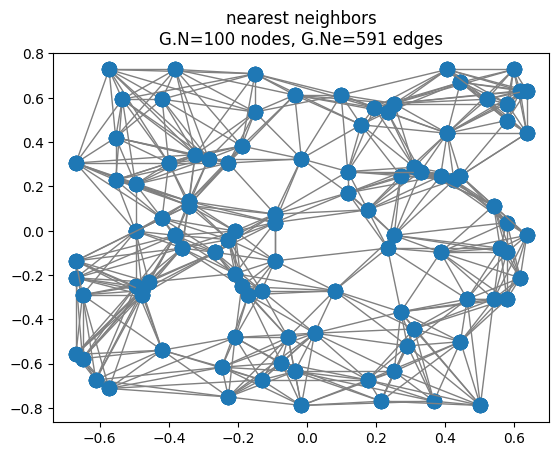

In [3]:
seed_everything(SEED)
datasets_path = Path.cwd().parent.joinpath("data", "tv-graph-datasets").absolute()
curr_dataset_path = datasets_path.joinpath("sea-surface-temperature.mat")
adjacency, jtv_signal = init_knn_from_mat(
    curr_dataset_path,
    knn_count=KNN_COUNT,
    knn_sigma=KNN_SIGMA,
    max_node_count=MAX_NODE_COUNT,
    max_time_length=MAX_TIME_LENGTH,
    device=DEVICE,
    verbose=GRAPH_VERBOSE,
)
gft = GFT(adjacency, EIGVAL_SORT_STRATEGY)
gfrft = GFRFT(gft.gft_mtx)

In [39]:
def experiment(
    gfrft: GFRFT,
    original_signals: th.Tensor,
    initial_orders: List[float],
    cutoff_counts: List[int],
    noise_sigma: float,
    *,
    noise_mean: float = 0.0,
    dim: int = -1,
    lr: float = 5e-4,
    epochs: int = 1000,
    display_epochs: Iterable[int] | None = None,
    seed: int = 0,
    trainable: bool = True,
) -> nn.Module:
    if len(initial_orders) != len(cutoff_counts):
        raise ValueError("initial_orders and cutoff_counts must have the same length")
    if display_epochs is None:
        display_epochs = (e for e in range(0, epochs, 100))
    display_epochs = set(display_epochs)

    seed_everything(seed)
    noisy_signals = add_gaussian_noise(original_signals, noise_sigma, noise_mean)
    filters = [
        GFRFTFilterLayer(gfrft, cutoff, order, trainable=trainable)
        for order, cutoff in zip(initial_orders, cutoff_counts)
    ]
    layers = [elem for pair in zip(filters, [Real()] * len(filters)) for elem in pair]
    model = nn.Sequential(*layers)
    print(model)
    print(f"learning rate: {lr}")
    optim = th.optim.Adam(model.parameters(), lr=lr)

    initial_loss = rmse_loss(noisy_signals, original_signals)
    print(f"Initial loss: {initial_loss.item():.4f}")
    for epoch in range(1, 1 + epochs):
        optim.zero_grad()
        output = rmse_loss(model(noisy_signals), original_signals)
        if epoch in display_epochs:
            print(f"Epoch {epoch:4d} | Loss {output.item(): >8.4f}")
        if not trainable:
            break
        output.backward()
        optim.step()
    return model


model = experiment(
    gfrft=gfrft,
    original_signals=jtv_signal,
    initial_orders=[0.0],
    cutoff_counts=[50],
    noise_sigma=10,
    lr=5e-3,
    dim=NODE_DIM,
    epochs=EPOCHS,
    display_epochs=[0, 1, 500, 1000, 1500, 2000],
    trainable=True,
)
model

Sequential(
  (0): GFRFTFilter(order=0.0, cutoff=50)
  (1): Real()
)
learning rate: 0.005
Initial loss: 10.0053
Epoch    1 | Loss  16.2750
Epoch  500 | Loss   7.1847
Epoch 1000 | Loss   7.1847
Epoch 1500 | Loss   7.1847
Epoch 2000 | Loss   7.1847


Sequential(
  (0): GFRFTFilter(order=1.0018677711486816, cutoff=50)
  (1): Real()
)